In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
import copy
from scipy.special import softmax
from scipy import stats

In [9]:
def cross_maze(grid_size: int):
    reward = [15,5]
    blocks = []
    mid_a = int(grid_size // 2)
    blocks_a = [[i, mid_a] for i in range(grid_size // 10, grid_size // 10 + 6)]
    blocks_b = [[i, mid_a] for i in range(grid_size - 7, grid_size - 2)]
    blocks_c = [[mid_a, i] for i in range(grid_size // 10 , grid_size - 2)]
    blocks = blocks_a + blocks_b + blocks_c
    valid_starts = []
    for i in range(grid_size):
        for j in range(grid_size):
            # check if position is not in blocks and is at least 10 tiles away from goal
            if [i, j] not in blocks and abs(i - (grid_size - 2)) + abs(j - 1) >= 10:
                valid_starts.append([i, j])
    # choose random start position from valid positions
    agent_start = random.choice(valid_starts)
    return blocks, agent_start, reward

In [10]:
class QLearningAgent:
    """
    Q-Learning Agent using softmax exploration
    """

    def __init__(
        self,
        env,
        state_size: int,
        lr: float,
        beta: float,
        action_size: int = 4,
        gamma: float = 0.99,
    ):
        self.reward = env[2]
        self.blocks = env[0]
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.Q = np.zeros((state_size, action_size))
        self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))

    def choose_action(self, state_idx):
      probs = softmax(self.Q[state_idx, :]*self.beta)
      action = np.random.choice(range(len(probs)), p=probs)
      return action
    def update_Q(self, state_idx, action, reward, next_state_idx, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state_idx, :])
        error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.lr * error

    def step(self, state, action, goal):
        step_reward = 0
        next_pos = [0, 0]
        if action == 0: #moving up
            next_pos = [state[0] - 1, state[1]]
        elif action == 1: #moving down
            next_pos = [state[0] + 1, state[1]]
        elif action == 2: #moving left
            next_pos = [state[0], state[1] - 1]
        elif action == 3: #moving right
            next_pos = [state[0], state[1] + 1]

        if next_pos[0] <= 0 or next_pos[1] <= 0 or next_pos[0] >= int(self.state_size ** 0.5) or next_pos[1] >= int(self.state_size ** 0.5):
            next_state = state
            step_reward = 0
        elif next_pos in self.blocks:
            next_state = state
            step_reward = -0.1
        elif next_pos == self.reward:
            next_state = next_pos
            step_reward = goal
        else:
            next_state = next_pos
            step_reward = 0
        next_state_idx = np.ravel_multi_index(next_state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
        return next_state_idx, step_reward, next_state == self.reward

    def reset_env(self):
      _, state, _ = cross_maze(grid_size)
      self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))
      return state

    def train(self, state, max_steps, goal):
        total_reward = 0
        step = 0
        suc = 0
        state_idx_list = []
        action_list = []
        reward_list = []
        for step in range(max_steps):
            state_idx = np.ravel_multi_index(state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state_idx_list.append(state_idx)
            action = self.choose_action(state_idx)
            action_list.append(action)
            next_state_idx, reward, done = self.step(state, action, goal)
            reward_list.append(reward)
            self.update_Q(state_idx, action, reward, next_state_idx, done)
            state = np.unravel_index(next_state_idx, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state = [state[0],state[1]]
            self.M[state[0],state[1]] += 1
            total_reward += reward
            step += 1
            if done:
                suc = 1
                break
        return total_reward, step, self.M, suc, state_idx_list, action_list, reward_list
    def replay(self, suc, step, state_idx_list, action_list, reward_list, success):
        my_list = list(range(0, step))
        if suc == success:
          for x in my_list[::-1]:
            # current step
            state_idx = state_idx_list[x-1]
            action = action_list[x-1]
            reward = reward_list[x-1]
            # next step
            next_action = action_list[x]
            next_state_idx = state_idx_list[x]
            # update Q values
            target = reward + self.gamma * self.Q[next_state_idx, next_action]
            error = target - self.Q[state_idx, action]
            self.Q[state_idx, action] += self.lr * error
            if x == 1:
              break

In [56]:
# Set agent parameters
grid_size = 20
state_size = grid_size ** 2
lr = 0.3
beta = 1
goal = 10
success = 1
n_episodes = 250
max_steps = 1000
trial = 100

# Initialize arrays to store the rewards and steps
rewards_replay_tot = np.zeros((trial, n_episodes))
rewards_no_replay_tot = np.zeros((trial, n_episodes))
steps_replay_tot = np.zeros((trial, n_episodes))
steps_no_replay_tot = np.zeros((trial, n_episodes))

# Run the simulation for 100 different agents with unique seeds
for i in range(trial):
    # Seed the random number generator for reproducibility
    np.random.seed(i)
    random.seed(i)

    # Create a new environment and agents for this trial
    env = cross_maze(grid_size)
    agent_replay = QLearningAgent(env, state_size, lr, beta)
    agent_no_replay = QLearningAgent(env, state_size, lr, beta)

    rewards_replay = []
    rewards_no_replay = []
    steps_replay = []
    steps_no_replay = []

    # Train each agent with and without replay
    for episode in range(n_episodes):
        # Train with replay
        state_re = agent_replay.reset_env()
        rews, step, M, suc, state_idx_list, action_list, reward_list = agent_replay.train(state_re, max_steps, goal)
        agent_replay.replay(suc, step, state_idx_list, action_list, reward_list, success)
        rewards_replay.append(rews)
        steps_replay.append(step)


        # Train without replay
        state = agent_no_replay.reset_env()
        rews, step, M, suc, state_idx_list, action_list, reward_list = agent_no_replay.train(state, max_steps, goal)
        rewards_no_replay.append(rews)
        steps_no_replay.append(step)

    rewards_replay_tot[i, :] = rewards_replay
    rewards_no_replay_tot[i, :] = rewards_no_replay
    steps_replay_tot[i, :] = steps_replay
    steps_no_replay_tot[i, :] = steps_no_replay

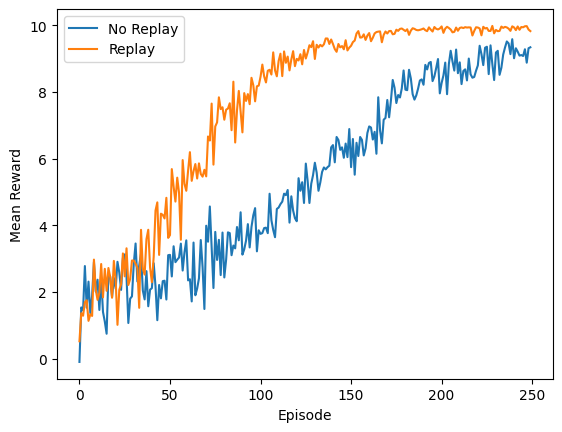

Mean rewards (no replay): 5.401052
Mean rewards (replay): 7.591143999999999
Independent t-test results:
t-statistic: -21.63634272812156
p-value: 4.636277187512922e-54


In [57]:
# Calculate the mean rewards across all trials
mean_rewards_no_replay = np.mean(rewards_no_replay_tot, axis=0)
mean_rewards_replay = np.mean(rewards_replay_tot, axis=0)

# Plot the mean rewards over episodes
plt.plot(mean_rewards_no_replay, label="No Replay")
plt.plot(mean_rewards_replay, label="Replay")
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.legend()
plt.show()

# Calculate the overall average rewards across all episodes and trials for each group
print("Mean rewards (no replay):", np.mean(mean_rewards_no_replay))
print("Mean rewards (replay):", np.mean(mean_rewards_replay))

# Perform independent t-test of the two groups over trials
t_statistic_rwd, p_value_rwd = stats.ttest_ind(np.mean(rewards_no_replay_tot, axis=1), np.mean(rewards_replay_tot, axis=1))

# Print the results
print("Independent t-test results:")
print("t-statistic:", t_statistic_rwd)
print("p-value:", p_value_rwd)

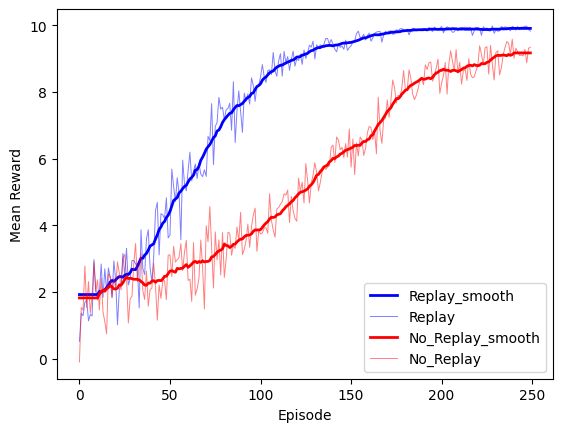

In [63]:
# Set the window size for the moving average and the total number of episodes
window = 20
length = n_episodes

# Initialize an array to store the smoothed rewards for both conditions
rewards_replay_smooth = np.zeros((length))
rewards_no_replay_smooth = np.zeros((length))

# Smooth the reward data of the replay condition
for i in range (0,int(window/2)):
  rewards_replay_smooth[i] = np.mean(mean_rewards_replay[0:int(window)])

for i in range (int(window/2),int(length-window/2)):
  rewards_replay_smooth[i] = np.mean(mean_rewards_replay[i-int(window/2):i+int(window/2)])

for i in range (int(length-window/2),length):
  rewards_replay_smooth[i] = np.mean(mean_rewards_replay[length-int(window):length])

# Smooth the reward data of the no replay condition
for i in range (0,int(window/2)):
  rewards_no_replay_smooth[i] = np.mean(mean_rewards_no_replay[0:int(window)])

for i in range (int(window/2),int(length-window/2)):
  rewards_no_replay_smooth[i] = np.mean(mean_rewards_no_replay[i-int(window/2):i+int(window/2)])

for i in range (int(length-window/2),length):
  rewards_no_replay_smooth[i] = np.mean(mean_rewards_no_replay[length-int(window):length])

# Plot the smoothed and original reward data for both replay and no replay conditions
plt.plot(rewards_replay_smooth, label="Replay_smooth", color = 'blue', linewidth = 2)
plt.plot(mean_rewards_replay, label="Replay", color = 'blue', alpha=0.5, linewidth = 0.7)
plt.plot(rewards_no_replay_smooth, label="No_Replay_smooth", color = 'red', linewidth = 2)
plt.plot(mean_rewards_no_replay, label="No_Replay", color = 'red', alpha=0.5, linewidth = 0.7)
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.legend()
plt.show()

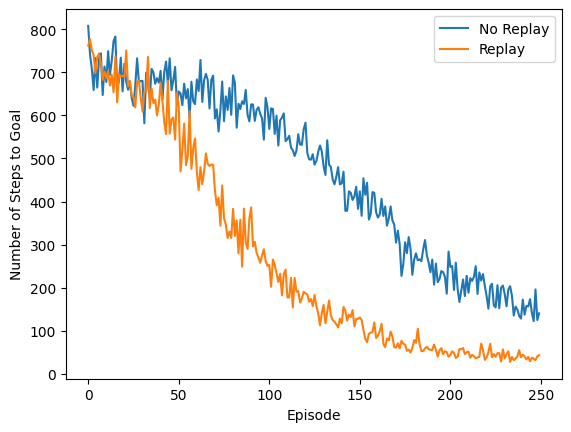

Mean steps (no replay): 465.60548
Mean steps (replay): 270.00084000000004
Independent t-test results:
t-statistic: 26.753371606125313
p-value: 1.1318023890635258e-67


In [59]:
# Calculate the mean steps to goal across all trials
mean_steps_no_replay = np.mean(steps_no_replay_tot, axis=0)
mean_steps_replay = np.mean(steps_replay_tot, axis=0)

# Plot the mean steps to goal over episodes
plt.plot(mean_steps_no_replay, label="No Replay")
plt.plot(mean_steps_replay, label="Replay")
plt.xlabel("Episode")
plt.ylabel("Number of Steps to Goal")
plt.legend()
plt.show()

# Calculate the overall average steps across all episodes and trials for each group
print("Mean steps (no replay):", np.mean(mean_steps_no_replay))
print("Mean steps (replay):", np.mean(mean_steps_replay))

# Perform independent t-test of the two groups over trials
t_statistic_steps, p_value_steps = stats.ttest_ind(np.mean(steps_no_replay_tot, axis=1), np.mean(steps_replay_tot, axis=1))

# Print the results
print("Independent t-test results:")
print("t-statistic:", t_statistic_steps)
print("p-value:", p_value_steps)

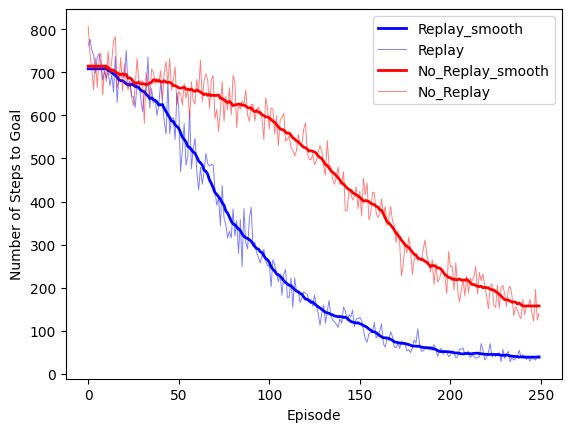

In [62]:
# Set the window size for the moving average and the total number of episodes
window = 20
length = n_episodes

# Initialize an array to store the smoothed step data for both conditions
steps_replay_smooth = np.zeros((length))
steps_no_replay_smooth = np.zeros((length))

# Smooth the step data of the replay condition
for i in range (0,int(window/2)):
  steps_replay_smooth[i] = np.mean(mean_steps_replay[0:int(window)])

for i in range (int(window/2),int(length-window/2)):
  steps_replay_smooth[i] = np.mean(mean_steps_replay[i-int(window/2):i+int(window/2)])

for i in range (int(length-window/2),length):
  steps_replay_smooth[i] = np.mean(mean_steps_replay[length-int(window):length])

# Smooth the step data of the no replay condition
for i in range (0,int(window/2)):
  steps_no_replay_smooth[i] = np.mean(mean_steps_no_replay[0:int(window)])

for i in range (int(window/2),int(length-window/2)):
  steps_no_replay_smooth[i] = np.mean(mean_steps_no_replay[i-int(window/2):i+int(window/2)])

for i in range (int(length-window/2),length):
  steps_no_replay_smooth[i] = np.mean(mean_steps_no_replay[length-int(window):length])

# Plot the smoothed and original step data for both replay and no replay conditions
plt.plot(steps_replay_smooth, label="Replay_smooth", color = 'blue', linewidth = 2)
plt.plot(mean_steps_replay, label="Replay", color = 'blue', alpha=0.5, linewidth = 0.7)
plt.plot(steps_no_replay_smooth, label="No_Replay_smooth", color = 'red', linewidth = 2)
plt.plot(mean_steps_no_replay, label="No_Replay", color = 'red', alpha=0.5, linewidth = 0.7)
plt.xlabel("Episode")
plt.ylabel("Number of Steps to Goal")
plt.legend()
plt.show()